In [1]:
from glob import glob
import numpy as np
import os
import gdal
from matplotlib import pyplot as plt
from src.segtools import export_tif
import subprocess
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
modeldirc = '/contents/predictions/processed/v1-00'
ref = np.array(sorted(glob('%s/*.tif'%(modeldirc))))
z = np.argsort(np.array([int(c.split('_')[2]) for c in ref]))
ref = list(ref[z])

def get_image_array(filename, band=0):
    return(1-(np.moveaxis(gdal.Open(filename).ReadAsArray(), 0, -1)[:,:,band]/255))

def gen_border_mask(filename):
    im = get_image_array(filename, band=3)
    mask = np.ones(np.shape(im)).astype('bool')
    mask[im==1] = False
    col_off = np.argmin(mask[0,:])
    row_off = np.argmin(mask[:,0])
    if col_off == 0:
        col_off = np.shape(im)[1]
    if row_off == 0:
        row_off = np.shape(im)[0]
    offsets = (row_off, col_off)
    return(mask, offsets)
     

# Trying to build a feature layer of 5km2 bounding boxes

In [ ]:
#clip the image
for i in range(len(ref)):
    im = get_image_array(ref[i])
    mask, offsets = gen_border_mask(ref[i])
    outdirc = '%s/mosaic'%(modeldirc)
    if (not os.path.exists(outdirc)):
        os.mkdir(outdirc) 
    outname = '%s/%s'%(outdirc, os.path.basename(ref[i]))
    export_tif(im[:offsets[0],:offsets[1]], gdal.Open(ref[i]), outname, alpha_mask=None)

mosaic_file = '%s/clippedmosaic.vrt'%(outdirc)
mosaic_cmd = "gdalbuildvrt -srcnodata 0 %s %s/*.tif"%(mosaic_file, outdirc)
p = subprocess.Popen(mosaic_cmd, stdout=subprocess.PIPE, \
                     stderr=subprocess.STDOUT, shell=True)
stdout, stderr = p.communicate()
print(stdout)


In [ ]:
# try to get a raster mask that aggregates at a 5km resolution of counts above the 0.35 probability
mosaic_f = '/contents/predictions/processed/v1-00/mosaic/clippedmosaic.vrt'
mosaic = gdal.Open(mosaic_f)
gt = mosaic.GetGeoTransform()
proj = mosaic.GetProjection()
agg_size = 5000 #(trying for 5km)
cellsize = gt[1]*agg_size
numx = mosaic.RasterXSize // agg_size + 1
numy = mosaic.RasterYSize // agg_size + 1
num_features = numx*numy
data = mosaic.GetRasterBand(1).ReadAsArray()
print(gt, proj, cellsize)
print(numx, numy)
print('%s,%s'%(mosaic.RasterXSize, mosaic.RasterYSize))

In [ ]:
#summarize the cells...
thr = 0.035
counts = np.zeros((numy, numx)).astype('uint8')
for row in range(numy):
    for col in range(numx):
        if (row ==(numy-1)) and (col==(numx-1)):
            cellcount = data[(row*agg_size):, (col*agg_size):]
        elif row ==(numy-1):
            cellcount = data[(row*agg_size):, (col*agg_size):((col+1)*agg_size)]
        elif col ==(numx-1):
            cellcount = data[(row*agg_size):((row+1)*agg_size), (col*agg_size):]
        else:
            cellcount = data[(row*agg_size):((row+1)*agg_size), (col*agg_size):((col+1)*agg_size)]
        counts[row, col] = int(np.sum(cellcount>=thr)/1000) #units are km2 

In [ ]:
print(counts)
plt.imshow(counts)

In [ ]:
outdirc = '%s/colorized'%(modeldirc)
mosaic_file = '%s/cmosaic.vrt'%(outdirc)
print(gdal.Open(mosaic_file).GetGeoTransform())

In [ ]:
ref = gdal.Open('/contents/predictions/processed/v1-00/mosaic/clippedmosaic.vrt')
print(ref.GetGeoTransform(), ref.RasterXSize, ref.RasterYSize)

In [ ]:
mosaic_dirc = '/contents/predictions/processed/v1-00'j
#use a ref
ref = gdal.Open('%s/mosaic/clippedmosaic.vrt'%mosaic_dirc)
gt = ref.GetGeoTransform()
proj = ref.GetProjection()
cellsize = gt[1]*5000
#export this as a tiff
outname='%s/mosaic/mosaic_counts.tif'%(mosaic_dirc)
gt_out = [gt[0], cellsize, gt[2], gt[3], gt[4], -cellsize]
proj_out = proj
xsize_out = numx
ysize_out = numy
driver = gdal.GetDriverByName('GTiff')
out = driver.Create(outname, xsize_out, ysize_out, 4, gdal.GDT_Byte)
out.SetGeoTransform(gt_out)
out.SetProjection(proj)
out.GetRasterBand(1).WriteArray(counts)
out.GetRasterBand(2).WriteArray(np.zeros(np.shape(counts)))
out.GetRasterBand(3).WriteArray(np.zeros(np.shape(counts)))
out.GetRasterBand(4).WriteArray(np.ones(np.shape(counts))*255)

out = None

In [ ]:
a = gdal.Open(outname).ReadAsArray()
print(a)

In [ ]:
tile_cmd = "python ./src/gdal2tiles2.py --processes 7 -z 4-13 -v %s %s/mosaic/tiles"%(outname, \
                                                                               mosaic_dirc)
p = subprocess.Popen(tile_cmd, stdout=subprocess.PIPE, \
                     stderr=subprocess.STDOUT, shell=True)
stdout, stderr = p.communicate()
print(stdout)


In [ ]:
'''# we want to make a geojson 
{"type": "FeatureCollection", \
 "features":\
 [{"type": "Feature", \
               "geometry":{"type": "Polygon",\
                           "coordinates":[[[minx,maxy],[maxx,maxy],[maxx,miny],[minx,miny],[minx,maxy]]]}}],\
 [{"type": "Feature", \
               "geometry":{"type": "Polygon", \
                           "coordinates":[[[x,y],[x,y],[x,y],[x,y]]]}}],\
}
'''

# END feature construction and mask

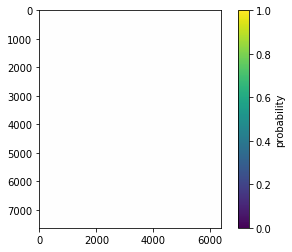

In [3]:
i=0
im = get_image_array(ref[i])
mask, offsets = gen_border_mask(ref[i])
mapped = (plt.cm.viridis_r(im)).astype('uint8')
plt.imshow(mapped)
cb = plt.colorbar()
cb.set_label('probability')
plt.savefig('/contents/assets/colorbar.png', dpi=600, bbox_inches='tight')

#### try colorizing


What we would like is for all the pixels that are above the threshold to become yellow and all those below to be blue.

In [7]:
#creating a threshold layer
thrs = [0.001, 0.01, 0.05, 0.10, 0.35]
for thr in thrs:
    for i in range(len(ref)):
        im = 1-get_image_array(ref[i])
        _, offsets = gen_border_mask(ref[i])
        mask = np.zeros(im.shape).astype('uint8')
        mask[im>=thr] = 255  
        mapped = (255*plt.cm.viridis(mask)).astype('uint8')
        outdirc = '%s/colorized/bin/%02d'%(modeldirc, thr*100)
        if (not os.path.exists(outdirc)):
            os.mkdir(outdirc) 
        outname = '%s/%s'%(outdirc, os.path.basename(ref[i]))
        export_tif(mapped[:offsets[0],:offsets[1],:], gdal.Open(ref[i]), outname, alpha_mask=True)
    mosaic_file = '%s/binmosaic.vrt'%(outdirc)
    mosaic_cmd = "gdalbuildvrt -srcnodata 0 %s %s/*.tif"%(mosaic_file, outdirc)
    p = subprocess.Popen(mosaic_cmd, stdout=subprocess.PIPE, \
                     stderr=subprocess.STDOUT, shell=True)
    stdout, stderr = p.communicate()
    print(stdout)

created /contents/predictions/processed/v1-00/colorized/bin/10/HotC_polyimage_0_USDA_NAIP_DOQQ_m_3711501_ne_11_1_20150725.tif
created /contents/predictions/processed/v1-00/colorized/bin/10/HotC_polyimage_1_USDA_NAIP_DOQQ_m_3711501_nw_11_1_20150725.tif
created /contents/predictions/processed/v1-00/colorized/bin/10/HotC_polyimage_2_USDA_NAIP_DOQQ_m_3711501_se_11_1_20150725.tif
created /contents/predictions/processed/v1-00/colorized/bin/10/HotC_polyimage_3_USDA_NAIP_DOQQ_m_3711501_sw_11_1_20150725.tif
created /contents/predictions/processed/v1-00/colorized/bin/10/HotC_polyimage_4_USDA_NAIP_DOQQ_m_3711502_nw_11_1_20150725.tif
created /contents/predictions/processed/v1-00/colorized/bin/10/HotC_polyimage_5_USDA_NAIP_DOQQ_m_3711502_sw_11_1_20150725.tif
created /contents/predictions/processed/v1-00/colorized/bin/10/HotC_polyimage_6_USDA_NAIP_DOQQ_m_3711509_ne_11_1_20150725.tif
created /contents/predictions/processed/v1-00/colorized/bin/10/HotC_polyimage_7_USDA_NAIP_DOQQ_m_3711509_nw_11_1_20150

In [9]:
thrs = [0.001, 0.01, 0.05, 0.10, 0.35]
for thr in thrs:
    outdirc = '%s/colorized/bin/%02d'%(modeldirc, thr*100)
    mosaic_file = '%s/binmosaic.vrt'%(outdirc)
    tile_cmd = "python ./src/gdal2tiles2.py --processes 7 -z 7-17 -v %s %s/tiles"%(mosaic_file, \
                                                                           outdirc)
    p = subprocess.Popen(tile_cmd, stdout=subprocess.PIPE, \
                 stderr=subprocess.STDOUT, shell=True)
    stdout, stderr = p.communicate()
    print(stdout)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
outdirc = '%s/colorized/bin'%(modeldirc)
mosaic_file = '%s/binmosaic.vrt'%(outdirc)
mosaic_cmd = "gdalbuildvrt -srcnodata 0 %s %s/*.tif"%(mosaic_file, outdirc)
tile_cmd = "python ./src/gdal2tiles2.py --processes 7 -z 4-17 -v %s %s/tiles"%(mosaic_file, \
                                                                               outdirc)
print(mosaic_cmd)
print(tile_cmd)

In [ ]:
start = time.time()
p = subprocess.Popen(mosaic_cmd, stdout=subprocess.PIPE, \
                     stderr=subprocess.STDOUT, shell=True)
stdout, stderr = p.communicate()
print(stdout)
p = subprocess.Popen(tile_cmd, stdout=subprocess.PIPE, \
                     stderr=subprocess.STDOUT, shell=True)
stdout, stderr = p.communicate()
print(stdout)
print(time.time() - start)